In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import os

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import os
import hashlib

def get_image_hash(file_path):
    """Возвращает md5-хэш изображения."""
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Пути к датасетам
isic_2019_path = '/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
siim_isic_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'

# Словари для хранения хэшей
isic_2019_hashes = {}
siim_isic_hashes = {}

# Генерация хэшей для ISIC-2019
count = 0
for root, _, files in os.walk(isic_2019_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_hash = get_image_hash(file_path)
        isic_2019_hashes[file_hash] = file_path
        
        count += 1
        if count % 1000 == 0:
            print(f"Завершено (ISIC-2019):{count / 25300 * 100}%")

# Генерация хэшей для SIIM-ISIC
count = 0
for root, _, files in os.walk(siim_isic_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_hash = get_image_hash(file_path)
        siim_isic_hashes[file_hash] = file_path
        count += 1
        if count % 1000 == 0:
            print(f"Завершено (ISIC-SIIM):{count / 33100 * 100}%")

# Поиск совпадений
duplicates = set(isic_2019_hashes.keys()) & set(siim_isic_hashes.keys())
print(f"Найдено {len(duplicates)} дублирующихся изображений.")

for dup in duplicates:
    print(f"Дубликат: {isic_2019_hashes[dup]} и {siim_isic_hashes[dup]}")


Завершено (ISIC-2019):3.9525691699604746%
Завершено (ISIC-2019):7.905138339920949%
Завершено (ISIC-2019):11.857707509881422%
Завершено (ISIC-2019):15.810276679841898%
Завершено (ISIC-2019):19.76284584980237%
Завершено (ISIC-2019):23.715415019762844%
Завершено (ISIC-2019):27.66798418972332%
Завершено (ISIC-2019):31.620553359683797%
Завершено (ISIC-2019):35.573122529644266%
Завершено (ISIC-2019):39.52569169960474%
Завершено (ISIC-2019):43.47826086956522%
Завершено (ISIC-2019):47.43083003952569%
Завершено (ISIC-2019):51.38339920948617%
Завершено (ISIC-2019):55.33596837944664%
Завершено (ISIC-2019):59.28853754940712%
Завершено (ISIC-2019):63.24110671936759%
Завершено (ISIC-2019):67.19367588932806%
Завершено (ISIC-2019):71.14624505928853%
Завершено (ISIC-2019):75.09881422924902%
Завершено (ISIC-2019):79.05138339920948%
Завершено (ISIC-2019):83.00395256916995%
Завершено (ISIC-2019):86.95652173913044%
Завершено (ISIC-2019):90.9090909090909%
Завершено (ISIC-2019):94.86166007905138%
Завершено (

In [3]:
isic_2019_path = '/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
siim_isic_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
names_isic2019 = set(os.listdir(isic_2019_path))
names_isic_siim = set(os.listdir(siim_isic_path))

inter = names_isic2019 & names_isic_siim

In [5]:
len(inter)

0

In [51]:
targets = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")
targets.set_index("image", inplace=True)
targets = pd.DataFrame(targets[["MEL", "BCC", "SCC", "AK"]])

In [52]:
targets = targets.sum(axis=1)

In [25]:
targets = targets.sum(axis=1).apply(lambda x: "benign" if x == 0 else "malignant")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


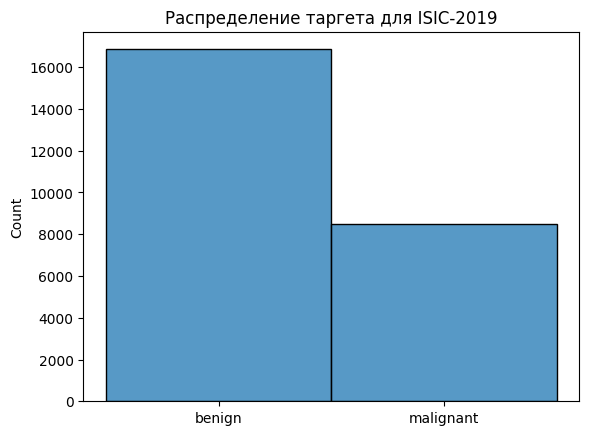

In [31]:
fig = plt.figure()
plt.title("Распределение таргета для ISIC-2019")
hist = sns.histplot(targets)

In [5]:
target = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv")
target.set_index("image_name", inplace=True)
target = target["benign_malignant"]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


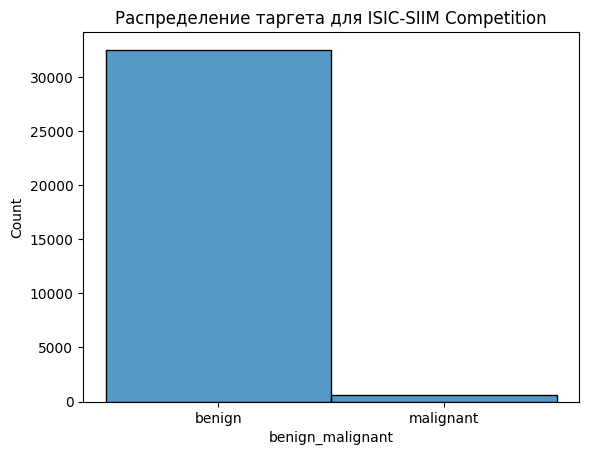

In [35]:
fig = plt.figure()
plt.title("Распределение таргета для ISIC-SIIM Competition")
hist = sns.histplot(target)

In [6]:
all_targets = pd.concat([targets, target], axis=0)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


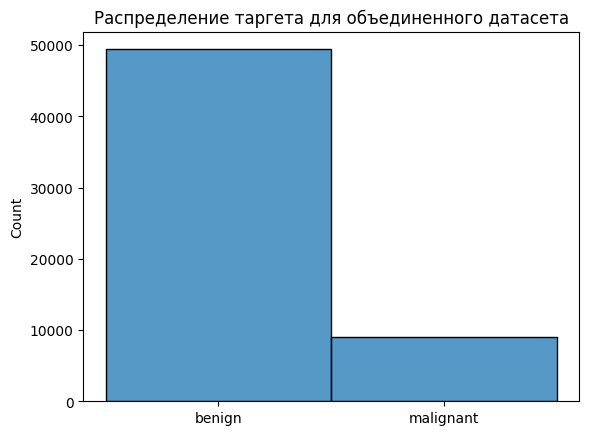

In [40]:
fig = plt.figure()
plt.title("Распределение таргета для объединенного датасета")
hist = sns.histplot(all_targets)

In [7]:
targets = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")
targets.set_index("image", inplace=True)

In [15]:
targets["MEL"].value_counts().iloc[1]

4522

In [17]:
val_count = {}
for col in targets.columns[:-1]:
    val_count[col] = targets[col].value_counts().iloc[1]

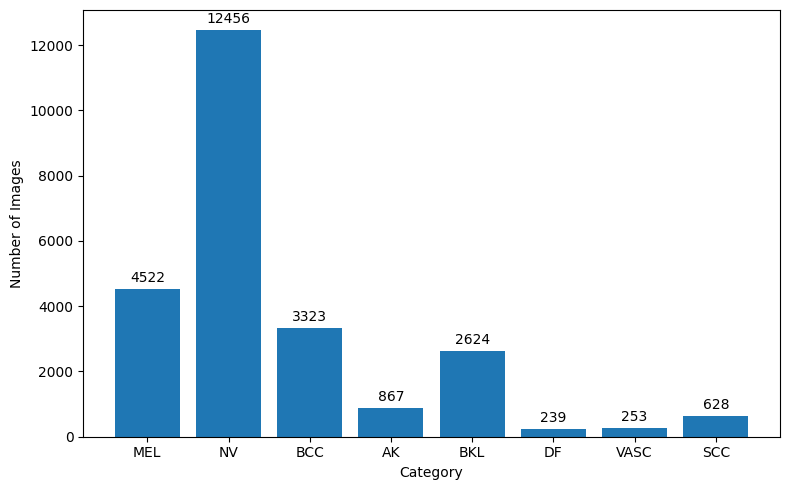

In [22]:
def autolabel(ax, rects):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    # References
        https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
# plt.bar(count_per_category.keys(), count_per_category.values())
rects = plt.bar(val_count.keys(), list(val_count.values()))
autolabel(ax, rects)
fig.tight_layout()

In [24]:
from sklearn.model_selection import train_test_split
train_target, val_target = train_test_split(targets, stratify=targets, test_size=0.2, random_state=42)

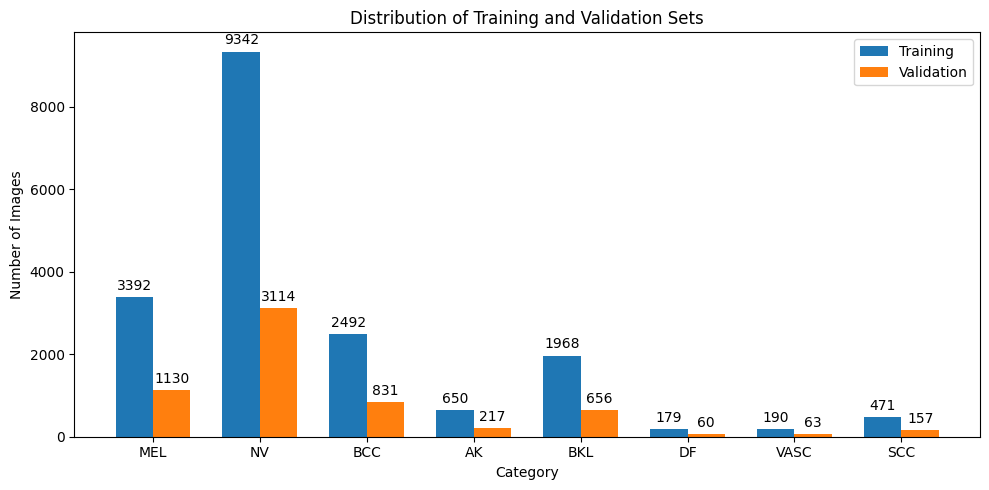

In [28]:
val_count_train = {}
for col in targets.columns[:-1]:
    val_count_train[col] = train_target[col].value_counts().iloc[1]
val_count_test = {}
for col in targets.columns[:-1]:
    val_count_test[col] = val_target[col].value_counts().iloc[1]

def plot_grouped_2bars(scalars, scalarlabels, xticklabels, title=None, xlabel=None, ylabel=None):
    x = np.arange(len(xticklabels))  # the label locations
    width = 0.35  # the width of the bars

    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    fig.patch.set_facecolor('white')
    rects1 = ax.bar(x - width/2, scalars[0], width, label=scalarlabels[0])
    rects2 = ax.bar(x + width/2, scalars[1], width, label=scalarlabels[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.legend()
    autolabel(ax, rects1)
    autolabel(ax, rects2)
    fig.tight_layout()
plot_grouped_2bars(
    scalars=[list(val_count_train.values()),
             list(val_count_test.values())],
    scalarlabels=['Training', 'Validation'],
    xticklabels=val_count_train.keys(),
    xlabel='Category',
    ylabel='Number of Images',
    title='Distribution of Training and Validation Sets'
)

In [ ]:
from sklearn.utils import class_weight

def load_isic_training_data(df_ground_truth):

#     known_category_names = list(df_ground_truth.columns.values[1:9])
#     unknown_category_name = df_ground_truth.columns.values[9]
    
    # Add path and category columns
    #df_ground_truth['path'] = df_ground_truth.apply(lambda row : os.path.join(image_folder, row['image']+'.jpg'), axis=1)
    df_ground_truth['category'] = np.argmax(np.array(df_ground_truth.iloc[:,:]), axis=1)
    return df_ground_truth

df_ground_truth = load_isic_training_data(train_target[train_target.columns[:-1]])

def compute_class_weight_dict(df):
    """Compute class weights for weighting the loss function on imbalanced data."""
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df['category']), y=df['category'])
    class_weight_dict = dict(enumerate(class_weights))
    return class_weight_dict, class_weights


class_weight_dict, class_weights = compute_class_weight_dict(df_ground_truth)
print('Class Weights Dictionary:')
print(class_weight_dict)

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(train_target.columns[:-1], class_weight_dict.values())

In [49]:
def load_isic_training_data(df_ground_truth):

#     known_category_names = list(df_ground_truth.columns.values[1:9])
#     unknown_category_name = df_ground_truth.columns.values[9]
    
    # Add path and category columns
    #df_ground_truth['path'] = df_ground_truth.apply(lambda row : os.path.join(image_folder, row['image']+'.jpg'), axis=1)
    df_ground_truth['category'] = np.argmax(np.array(df_ground_truth.iloc[:,:]), axis=1)
    return df_ground_truth

df_ground_truth = load_isic_training_data(train_target[train_target.columns[:-1]])

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import os
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.isotonic import IsotonicRegression
from torchvision import models

import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CustomDataset(Dataset):
    def __init__(self, target_bin, target_mult, img_size=512, mode="train"):
        self.img_size = img_size
        self.transform = A.Compose([
            A.RandomRotate90(),
            A.HorizontalFlip(),                       # Отражение изображения с вероятностью 50%
            A.VerticalFlip(),
            A.RandomBrightnessContrast(),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0)
        ])
        self.transform_test = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0)
        self.img_names = target_mult.index.to_list()
        self.mode = mode
        self.len_ = len(self.img_names)
        self.targets_bin = target_bin
        self.targets_mult = target_mult

    def __getitem__(self, index):
        img_name = self.img_names[index]
        if self.mode == "train":
            img_prep = self.preprocess(img_name)
        else:
            img = cv2.imread(img_name)
            if self.img_size != 512:
                img = cv2.resize(img, (self.img_size, self.img_size))
                img_prep = self.transform_test(image=img)["image"]
        label_bin = self.targets_bin.loc[img_name, "target"]
        label_mult = self.targets_mult.loc[img_name, "target"]

        return img_prep, label_bin, label_mult

    def __len__(self):
        return self.len_

    def preprocess(self, img_name):
        img = cv2.imread(img_name)
        if self.img_size != 512:
            img = cv2.resize(img, (self.img_size, self.img_size))
        img_trans = self.transform(image=img)["image"]
        return img_trans

In [33]:
os.rename("/kaggle/working/weights.pt", "/kaggle/working/effnetV2/weights.pt")

In [3]:
files_isic_2019 = os.listdir("/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/")
#files_siim = os.listdir("./dataset/data/")
files_isic_2019.remove("ATTRIBUTION.txt")
for name in files_isic_2019:
    if "L" in name:
        print("Yes")
        files_isic_2019.remove(name)


targets_isic_2019 = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")
targets_isic_2019["image"] = targets_isic_2019["image"].apply(lambda x:"/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/" + x + ".jpg")
targets_isic_2019.set_index("image", inplace=True)

target_mult = targets_isic_2019.copy()
target_mult.drop(columns=["DF", "VASC"], inplace=True)
target_mult.drop(columns=["UNK"], inplace=True)
class_names = target_mult.columns
target_mult = pd.DataFrame(np.argmax(np.array(target_mult.loc[:,:]), axis=1), columns=["target"], index=target_mult.index)
targets_isic_2019 = pd.DataFrame(targets_isic_2019[["MEL", "BCC", "SCC", "AK"]])
targets_isic_2019 = pd.DataFrame(targets_isic_2019.sum(axis=1), columns=["target"])



# target_siim = pd.read_csv("./dataset/train_target.csv", index_col=0)
# target_siim.rename(columns={"image_name": "image"}, inplace=True)
# target_siim["image"] = target_siim["image"].apply(lambda x: "./dataset/data/" + x + ".jpg")
# target_siim.set_index("image", inplace=True)
# target_siim = target_siim["target"]

# target = pd.concat([target_siim, targets_isic_2019], axis=0)
target_bin = targets_isic_2019
traget_mult = target_mult[target_mult["target"] != 5]
traget_mult = target_mult[target_mult["target"] != 6]

Yes


In [4]:
from sklearn.model_selection import train_test_split
train_target, val_target = train_test_split(target_mult, stratify=target_mult, test_size=0.15, random_state=42)
train_target, hold_target = train_test_split(train_target, stratify=train_target, test_size=0.2, random_state=42)
train_target, test_target = train_test_split(train_target, stratify=train_target, test_size=0.2, random_state=42)

train_target_bin = target_bin.loc[train_target.index]
val_target_bin = target_bin.loc[val_target.index]
hold_target_bin = target_bin.loc[hold_target.index]
test_target_bin = target_bin.loc[test_target.index]
target_bin.loc[train_target.index].value_counts()

target
0.0       8699
1.0       5080
Name: count, dtype: int64

In [5]:
from sklearn.utils import class_weight

def compute_class_weight_dict(df):
    """Compute class weights for weighting the loss function on imbalanced data."""
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
    class_weight_dict = dict(enumerate(class_weights))
    return class_weight_dict, class_weights


class_weight_dict_bin, class_weights_bin = compute_class_weight_dict(train_target_bin)
print('Class Weights Dictionary:')
print(class_weight_dict_bin)

Class Weights Dictionary:
{0: 0.7919875847798598, 1: 1.356200787401575}


Class Weights Dictionary:
{0: 0.8421342134213421, 1: 0.3278840662478584, 2: 1.270890979524073, 3: 4.865466101694915, 4: 1.6093202522775052, 5: 6.714912280701754}


<BarContainer object of 6 artists>

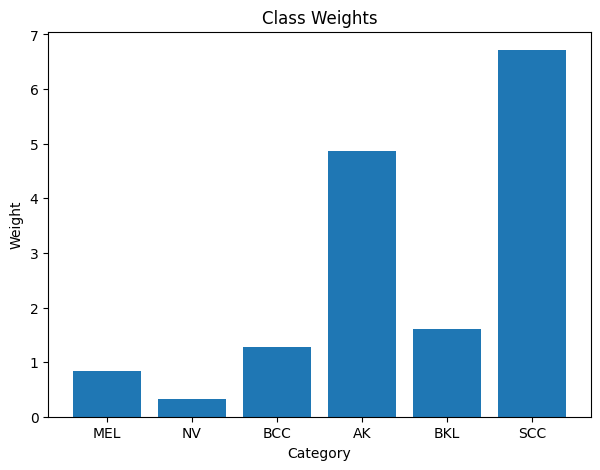

In [6]:
class_weight_dict_mult, class_weights_mult = compute_class_weight_dict(train_target)
print('Class Weights Dictionary:')
print(class_weight_dict_mult)

# Create a bar chart
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_title('Class Weights')
ax.set(xlabel='Category', ylabel='Weight')
plt.bar(class_names, class_weight_dict_mult.values())

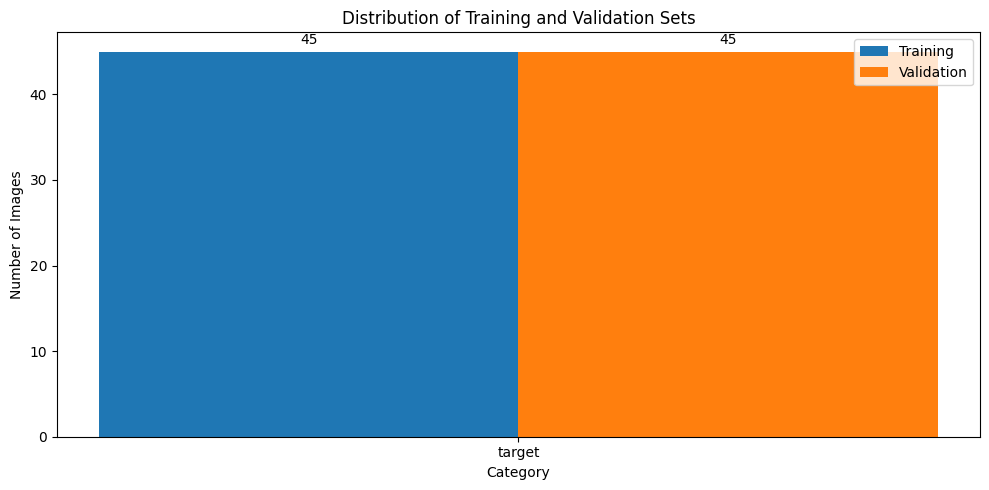

In [10]:
def autolabel(ax, rects):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    # References
        https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


val_count_train = {}
for col in target_mult.columns:
    val_count_train[col] = train_target[col].value_counts().iloc[1]
val_count_test = {}
for col in target_mult.columns:
    val_count_test[col] = val_target[col].value_counts().iloc[1]

def plot_grouped_2bars(scalars, scalarlabels, xticklabels, title=None, xlabel=None, ylabel=None):
    x = np.arange(len(xticklabels))  # the label locations
    width = 0.35  # the width of the bars

    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(title)
    fig.patch.set_facecolor('white')
    rects1 = ax.bar(x - width/2, scalars[0], width, label=scalarlabels[0])
    rects2 = ax.bar(x + width/2, scalars[1], width, label=scalarlabels[1])

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.legend()
    autolabel(ax, rects1)
    autolabel(ax, rects2)
    fig.tight_layout()
plot_grouped_2bars(
    scalars=[list(val_count_train.values()),
             list(val_count_test.values())],
    scalarlabels=['Training', 'Validation'],
    xticklabels=val_count_train.keys(),
    xlabel='Category',
    ylabel='Number of Images',
    title='Distribution of Training and Validation Sets'
)

In [23]:
train_dataset = CustomDataset(train_target_bin, train_target, img_size=224)
val_dataset = CustomDataset(val_target_bin, val_target, img_size=224, mode="test")
hold_dataset = CustomDataset(hold_target_bin, hold_target, img_size=224, mode="test")
test_dataset = CustomDataset(test_target_bin, test_target, img_size=224, mode="test")
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
hold_loader = DataLoader(hold_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
def train_and_validate(model, train_loader, val_loader, criterion_bin, criterion_mult, num_epochs, layers_to_unfreeze, name):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    os.mkdir(f"model_train_{name}")
    soft = nn.Softmax()
    history = [{"training": [], "validation": [], "recall": [], "precision": [], "recall_macro":[], "precision_macro":[]} for _ in range(len(layers_to_unfreeze))]
    best_weights = None
    lr = 1.5e-4
    for i, layer_group in enumerate(layers_to_unfreeze):
        # Размораживаем текущую группу слоев
        for layer in layer_group:
            for param in layer.parameters():
                param.requires_grad = True
        print(f"Unfreezeing layer groups: {i+1}/{len(layers_to_unfreeze)}")
        # Обновляем оптимизатор, чтобы включать только размороженные параметры
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        for epoch in range(num_epochs):
            # Тренировочный этап
            model.train()
            count = 0
            all_loss = 0.0
            train_progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
            for images, labels_bin, labels_mult in train_progress_bar:
                images, labels_bin, labels_mult = images.to(torch.float).to(device), labels_bin.to(torch.float).to(device), labels_mult.to(torch.long).to(device)
                images = images.permute(0, 3, 1, 2)
                optimizer.zero_grad()
                binary_output, multiclass_output = model(images)
                # Вычисляем лоссы для обеих задач
                loss_binary = criterion_bin(binary_output.squeeze(1), labels_bin)
                loss_multiclass = criterion_mult(multiclass_output.to(torch.float), labels_mult)

                # Общий лосс — сумма двух лоссов
                loss = loss_binary #+ loss_multiclass
                loss.backward()
                all_loss += loss.detach().cpu().numpy()
                optimizer.step()
                count += 1
            history[i]["training"].append(all_loss / count)
            
            # Этап валидации
            model.eval()
            all_preds_bin = []
            all_preds_mult = []
            all_labels_bin = []
            all_labels_mult = []
            with torch.no_grad():
                count = 0
                all_loss = 0.0
                for images, labels_bin, labels_mult in val_loader:
                    images, labels_bin, labels_mult = images.to(torch.float).to(device), labels_bin.to(torch.float).to(device), labels_mult.to(torch.long).to(device)
                    images = images.permute(0, 3, 1, 2)
                    binary_output, multiclass_output = model(images)
                    binary_probs = torch.sigmoid(binary_output.squeeze(1))
                    binary_preds = (binary_probs > 0.5).float()
                    multi_probs = F.softmax(multiclass_output, dim=1)
                    multi_preds = torch.argmax(multi_probs, dim=1)
                    # Вычисляем лоссы для обеих задач
                    loss_binary = criterion_bin(binary_output.squeeze(1), labels_bin)
                    loss_multiclass = criterion_mult(multiclass_output, labels_mult)

                    # Общий лосс — сумма двух лоссов
                    loss = loss_binary #+ loss_multiclass
                    all_preds_bin.extend(binary_preds.cpu().numpy())
                    all_preds_mult.extend(multi_preds.cpu().numpy())
                    all_labels_bin.extend(labels_bin.cpu().numpy())
                    all_labels_mult.extend(labels_mult.cpu().numpy())
                    count += 1
                    all_loss += loss.detach().cpu().numpy()
                history[i]["validation"].append(all_loss / count)
            
            # Вычисление F1-score для эпохи
            precision = precision_score(all_labels_bin, np.array(all_preds_bin))
            precision_macro = precision_score(all_labels_mult, all_preds_mult, average="macro")
            recall = recall_score(all_labels_bin, all_preds_bin)
            recall_macro = recall_score(all_labels_mult, all_preds_mult, average="macro")
            history[i]["precision"].append(precision)
            history[i]["recall"].append(recall)
            history[i]["precision_macro"].append(precision_macro)
            history[i]["recall_macro"].append(recall_macro)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {history[i]["training"][-1]:.4f}, Val loss: {history[i]["validation"][-1]:.4f}, Recall_bin: {recall:.4f}, Precision_bin: {precision:.4f}, Recall_mult: {recall_macro:.4f}, Precision_mult: {precision_macro:.4f}')
            if len(history[i]["validation"]) > 2:
                if history[i]["validation"][-1] > history[i]["validation"][-2] and history[i]["validation"][-1] > history[i]["validation"][-3]:
                    break
                if  history[i]["validation"][-1] > history[i]["validation"][-2]:
                    if (history[i]["recall"][-1] == max(history[i]["recall"]) and max(history[i]["recall_macro"]) - history[i]["recall_macro"][-1] < 0.03) or (history[i]["recall_macro"][-1] == max(history[i]["recall_macro"]) and max(history[i]["recall"]) - history[i]["recall"][-1] < 0.03):
                        best_weights = model.state_dict()
                        print("Best weigts saved")
            if len(history[i]["validation"]) <= 2:
                best_weights = model.state_dict()
                print("Best weigts saved")
            pd.DataFrame(history[i]).to_csv(f"./history_mult{i}.csv")
    return history, best_weights

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice
class DiceLossMulti(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.softmax(inputs)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice
class DiceBCELoss(nn.Module):
    def __init__(self, class_weight=None):
        super(DiceBCELoss, self).__init__()
        if class_weight is not None:
            self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weight[1] / class_weight[0]))
        else:
            self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return bce_loss + dice_loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Вычисляем обычный CrossEntropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        
        # Вычисляем вероятности для каждого класса
        pt = torch.exp(-ce_loss)
        
        # Применяем фокусирующий параметр
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class MultiLoss(nn.Module):
    def __init__(self, weights):
        super(MultiLoss, self).__init__()
        weights = torch.tensor(weights).to(device)
        self.focal = FocalLoss(alpha=weights, gamma=2)
        self.dice = DiceLossMulti()
    def forward(self, inputs, targets):
        return self.focal(inputs, targets) + self.dice(inputs, targets)

        

In [ ]:
pip install --upgrade timm

In [16]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes_multiclass):
        super(MultiTaskModel, self).__init__()
        
        # Загружаем предобученную модель EfficientNet-B0

        #self.backbone = timm.create_model('efficientnetv2_rw_t', pretrained=True)
        self.backbone = models.efficientnet_v2_s(weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1")
        #self.backbone = models.efficientnet_b1(weights="EfficientNet_B1_Weights.DEFAULT")
        # Изменяем последний слой, чтобы использовать его как общий экстрактор признаков
        num_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier = nn.Identity()  # Убираем классификационный слой
        
        # Головной слой для бинарной классификации
        self.binary_classifier = nn.Sequential(
            nn.Linear(num_features, 1),
            #nn.Sigmoid()  # Используем сигмоид для бинарной классификации
        )
        
        # Головной слой для многоклассовой классификации
        self.multiclass_classifier = nn.Sequential(
            nn.Linear(num_features, num_classes_multiclass)
            # Используем Softmax при вычислении потерь, так что здесь активация не нужна
        )
    def forward(self, x):
        # Пропускаем изображение через EfficientNet и получаем признаки
        features = self.backbone(x)

        # Пропускаем признаки через бинарный и многоклассовый классификаторы
        binary_output = self.binary_classifier(features)
        multiclass_output = self.multiclass_classifier(features)

        return binary_output, multiclass_output


# Пример инициализации модели
num_classes_multiclass = 6  # Задайте нужное количество классов для многоклассовой классификации
model = MultiTaskModel(num_classes_multiclass)

In [99]:
os.rmdir("/kaggle/working/model_train_vit_train_multitask/")

In [ ]:
for param in model.parameters():
    param.requires_grad = False

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Определение функции потерь и оптимизатора
criterion_bin = DiceBCELoss(class_weight=class_weight_dict_bin)
criterion_mult = FocalLoss(alpha=torch.tensor(class_weights_mult).to(torch.float), gamma=2)

# layers_to_unfreeze = [
#     [model.backbone.vit.encoder.layer[9:]] + [model.binary_classifier, model.multiclass_classifier],    # Сначала размораживаем последний блок (наиболее специализированный)
#     [model.backbone.vit.encoder.layer[6:9]],   # Затем предыдущие блоки
#     [model.backbone.vit.encoder.layer[3:6]],   # Дальше размораживаем еще более ранние блоки
#     [model.backbone.vit.encoder.layer[0:3]] + [model.backbone.vit.embeddings],   # В конце — самые ранние блоки
# ]

# Запуск тренировки и валидации
num_epochs = 5
history, best_weights = train_and_validate(model, train_loader, val_loader, criterion_bin, 
                                           criterion_mult, num_epochs, layers_to_unfreeze, "vit_train_multitask")
torch.save(best_weights, "weights.pt")
# model.load_state_dict(best_weights)

In [13]:
num_classes_multiclass = 6  # Задайте нужное количество классов для многоклассовой классификации
model = MultiTaskModel(num_classes_multiclass)

for param in model.parameters():
    param.requires_grad = False

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Определение функции потерь и оптимизатора
criterion_bin = DiceBCELoss(class_weight=class_weight_dict_bin)
criterion_mult = FocalLoss(alpha=torch.tensor(class_weights_mult).to(torch.float).to(device), gamma=2)

layers_to_unfreeze = [
    [model.backbone.blocks[5:]] + [model.backbone.conv_head, model.binary_classifier, model.multiclass_classifier],    # Сначала размораживаем последний блок (наиболее специализированный)
    [model.backbone.blocks[3:5]],   # Затем предыдущие блоки
    [model.backbone.blocks[2:4]],   # Дальше размораживаем еще более ранние блоки
    [model.backbone.blocks[0:2]],   # В конце — самые ранние блоки
]

# Запуск тренировки и валидации
num_epochs = 5
history, best_weights = train_and_validate(model, train_loader, val_loader, criterion_bin, criterion_mult, 
                                           num_epochs, layers_to_unfreeze, "effnetV2_binary")
torch.save(best_weights, "weights.pt")
# model.load_state_dict(best_weights)

FileExistsError: [Errno 17] File exists: 'model_train_effnetV2_binary'

In [36]:
def test_model(model, test_loader):
    all_preds = []
    all_test_labels = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    soft = nn.Softmax()
    with torch.no_grad():
        for images, _, labels in tqdm.tqdm(test_loader, desc="Завершено"):
            images = np.array(images)
            images = processor(images)['pixel_values'].to(device)
            logits = model(images).logits
            probs = soft(logits)
            preds = torch.argmax(probs, 1)
            preds[preds == 0] = 4
            preds[preds == 1] = 2
            preds[preds == 2] = 3
            preds[preds == 3] = 6
            preds[preds == 4] = 1
            preds[preds == 5] = 0
            preds[preds == 6] = 5
            all_preds.extend(preds.detach().cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
    return all_preds, all_test_labels

In [51]:
test_target = test_target[test_target["target"] != 7]
test_target_bin = test_target_bin.loc[test_target.index]

In [52]:
test_dataset = CustomDataset(test_target_bin, test_target, img_size=128, mode="test")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [43]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="Anwarkh1/Skin_Cancer-Image_Classification")
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("Anwarkh1/Skin_Cancer-Image_Classification", use_fast=True)
model = AutoModelForImageClassification.from_pretrained("Anwarkh1/Skin_Cancer-Image_Classification")

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [53]:
preds, labels = test_model(model, test_loader)

Завершено:   0%|          | 0/92 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Завершено: 100%|██████████| 92/92 [07:57<00:00,  5.19s/it]


In [56]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

f1 = f1_score(labels, preds, average="macro")
recall = recall_score(labels, preds, average="macro")
pres = precision_score(labels, preds, average="macro")
acc = accuracy_score(labels, preds)
print(f"ahishamm/vit-base-16-thesis-demo-ISIC-multi-class \nAccuracy: {acc:.3f}, Recall: {recall:.3f}, Presicion: {pres:.3f}, F1: {f1:.3f}")

ahishamm/vit-base-16-thesis-demo-ISIC-multi-class 
Accuracy: 0.521, Recall: 0.143, Presicion: 0.074, F1: 0.098


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
model.load_state_dict(torch.load("/kaggle/input/model_1/pytorch/default/1/weights_layer_group0_epoch_3.pth", weights_only=True))

<All keys matched successfully>

In [27]:
class DirichletCalibration(nn.Module):
    def __init__(self, num_classes):
        super(DirichletCalibration, self).__init__()
        # Линейный слой для преобразования логитов
        self.fc = nn.Linear(num_classes, num_classes, bias=False)
        
    def forward(self, logits):
        # Параметризация линейного слоя для каждого класса
        calibrated_logits = self.fc(logits)
        return calibrated_logits
device = "cuda" if torch.cuda.is_available() else "cpu"
# Создаем экземпляр DirichletCalibration для определенного количества классов
num_classes = 6  # Замените на количество классов в вашей задаче
dirichlet_calibration = DirichletCalibration(num_classes).to(device)
model.to(device)
# Подбор параметров калибровки
def calibrate_dirichlet(val_loader, model, dirichlet_calibration):
    """
    Подбирает параметры для Dirichlet Calibration на валидационном наборе данных.
    
    val_loader: DataLoader с валидационным набором данных
    model: основная модель классификации (выдает логиты)
    dirichlet_calibration: модуль DirichletCalibration
    """
    model.eval()
    dirichlet_calibration.train()
    
    # Оптимизатор для подбора весов Dirichlet-калибровки
    optimizer = optim.Adam(dirichlet_calibration.parameters(), lr=0.01)
    nll_criterion = nn.CrossEntropyLoss()

    for images, _, labels_mult in tqdm.tqdm(val_loader):
        optimizer.zero_grad()
        images, labels_mult = images.to(torch.float).to(device), labels_mult.to(device)
        images = images.permute(0, 3, 1, 2)
        _,logits = model(images)  # Получаем логиты от модели
        calibrated_logits = dirichlet_calibration(logits)
        loss = nll_criterion(calibrated_logits, labels_mult)
        loss.backward()
        optimizer.step()

# Пример вызова функции калибровки на валидационных данных
calibrate_dirichlet(val_loader, model, dirichlet_calibration)

# Функция для предсказания с калибровкой
def calibrated_predict(model, dirichlet_calibration, test_loader):
    """
    Предсказывает вероятности с учетом калибровки Dirichlet.
    
    model: основная модель классификации
    dirichlet_calibration: модуль DirichletCalibration
    images: батч изображений для предсказания
    """
    model.eval()
    dirichlet_calibration.eval()
    
    with torch.no_grad():
        for images, _, labels_mult in tqdm.tqdm(val_loader):
            images, labels_mult = images.to(torch.float).to(device), labels_mult.to(device)
            images = images.permute(0, 3, 1, 2)
            _, logits = model(images)
            calibrated_logits = dirichlet_calibration(logits)
            probabilities = F.softmax(calibrated_logits, dim=1)
    
    return probabilities

# Пример инференса:
# test_images - батч изображений
predictions = calibrated_predict(model, dirichlet_calibration, test_loader)

100%|██████████| 60/60 [00:44<00:00,  1.34it/s]


In [ ]:
def calibrated_predict(model, dirichlet_calibration, test_loader):
    """
    Предсказывает вероятности с учетом калибровки Dirichlet.
    
    model: основная модель классификации
    dirichlet_calibration: модуль DirichletCalibration
    images: батч изображений для предсказания
    """
    model.eval()
    dirichlet_calibration.eval()
    all_probs = []
    with torch.no_grad():
        for images, _, labels_mult in tqdm.tqdm(test_loader):
            images, labels_mult = images.to(torch.float).to(device), labels_mult.to(device)
            images = images.permute(0, 3, 1, 2)
            _, logits = model(images)
            calibrated_logits = dirichlet_calibration(logits)
            probabilities = F.softmax(calibrated_logits, dim=1)
            all_probs.extend(probabilities.cpu().numpy())
    return all_probs
predictions = calibrated_predict(model, dirichlet_calibration, test_loader)

 17%|█▋        | 9/54 [00:07<00:38,  1.16it/s]

In [36]:
from sklearn.metrics import accuracy_score
preds = np.argmax(predictions, axis=1)
labels = test_dataset.targets_mult["target"]

print(accuracy_score(labels, preds))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

torch.Size([24, 6])